In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import re
import nltk
from nltk.tokenize import word_tokenize
import contractions
import seaborn as sns


nltk.download('punkt_tab')

url = './kaggle_sentiment_data.csv'
data = pd.read_csv(url)

# Remove the first column
data = data.drop(data.columns[0], axis=1).copy()
# data = data.dropna(subset=['statement', 'status'])

print(data.head())
processed_data = data[["statement", "status"]]

print(processed_data.head())

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kaylee_bae/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


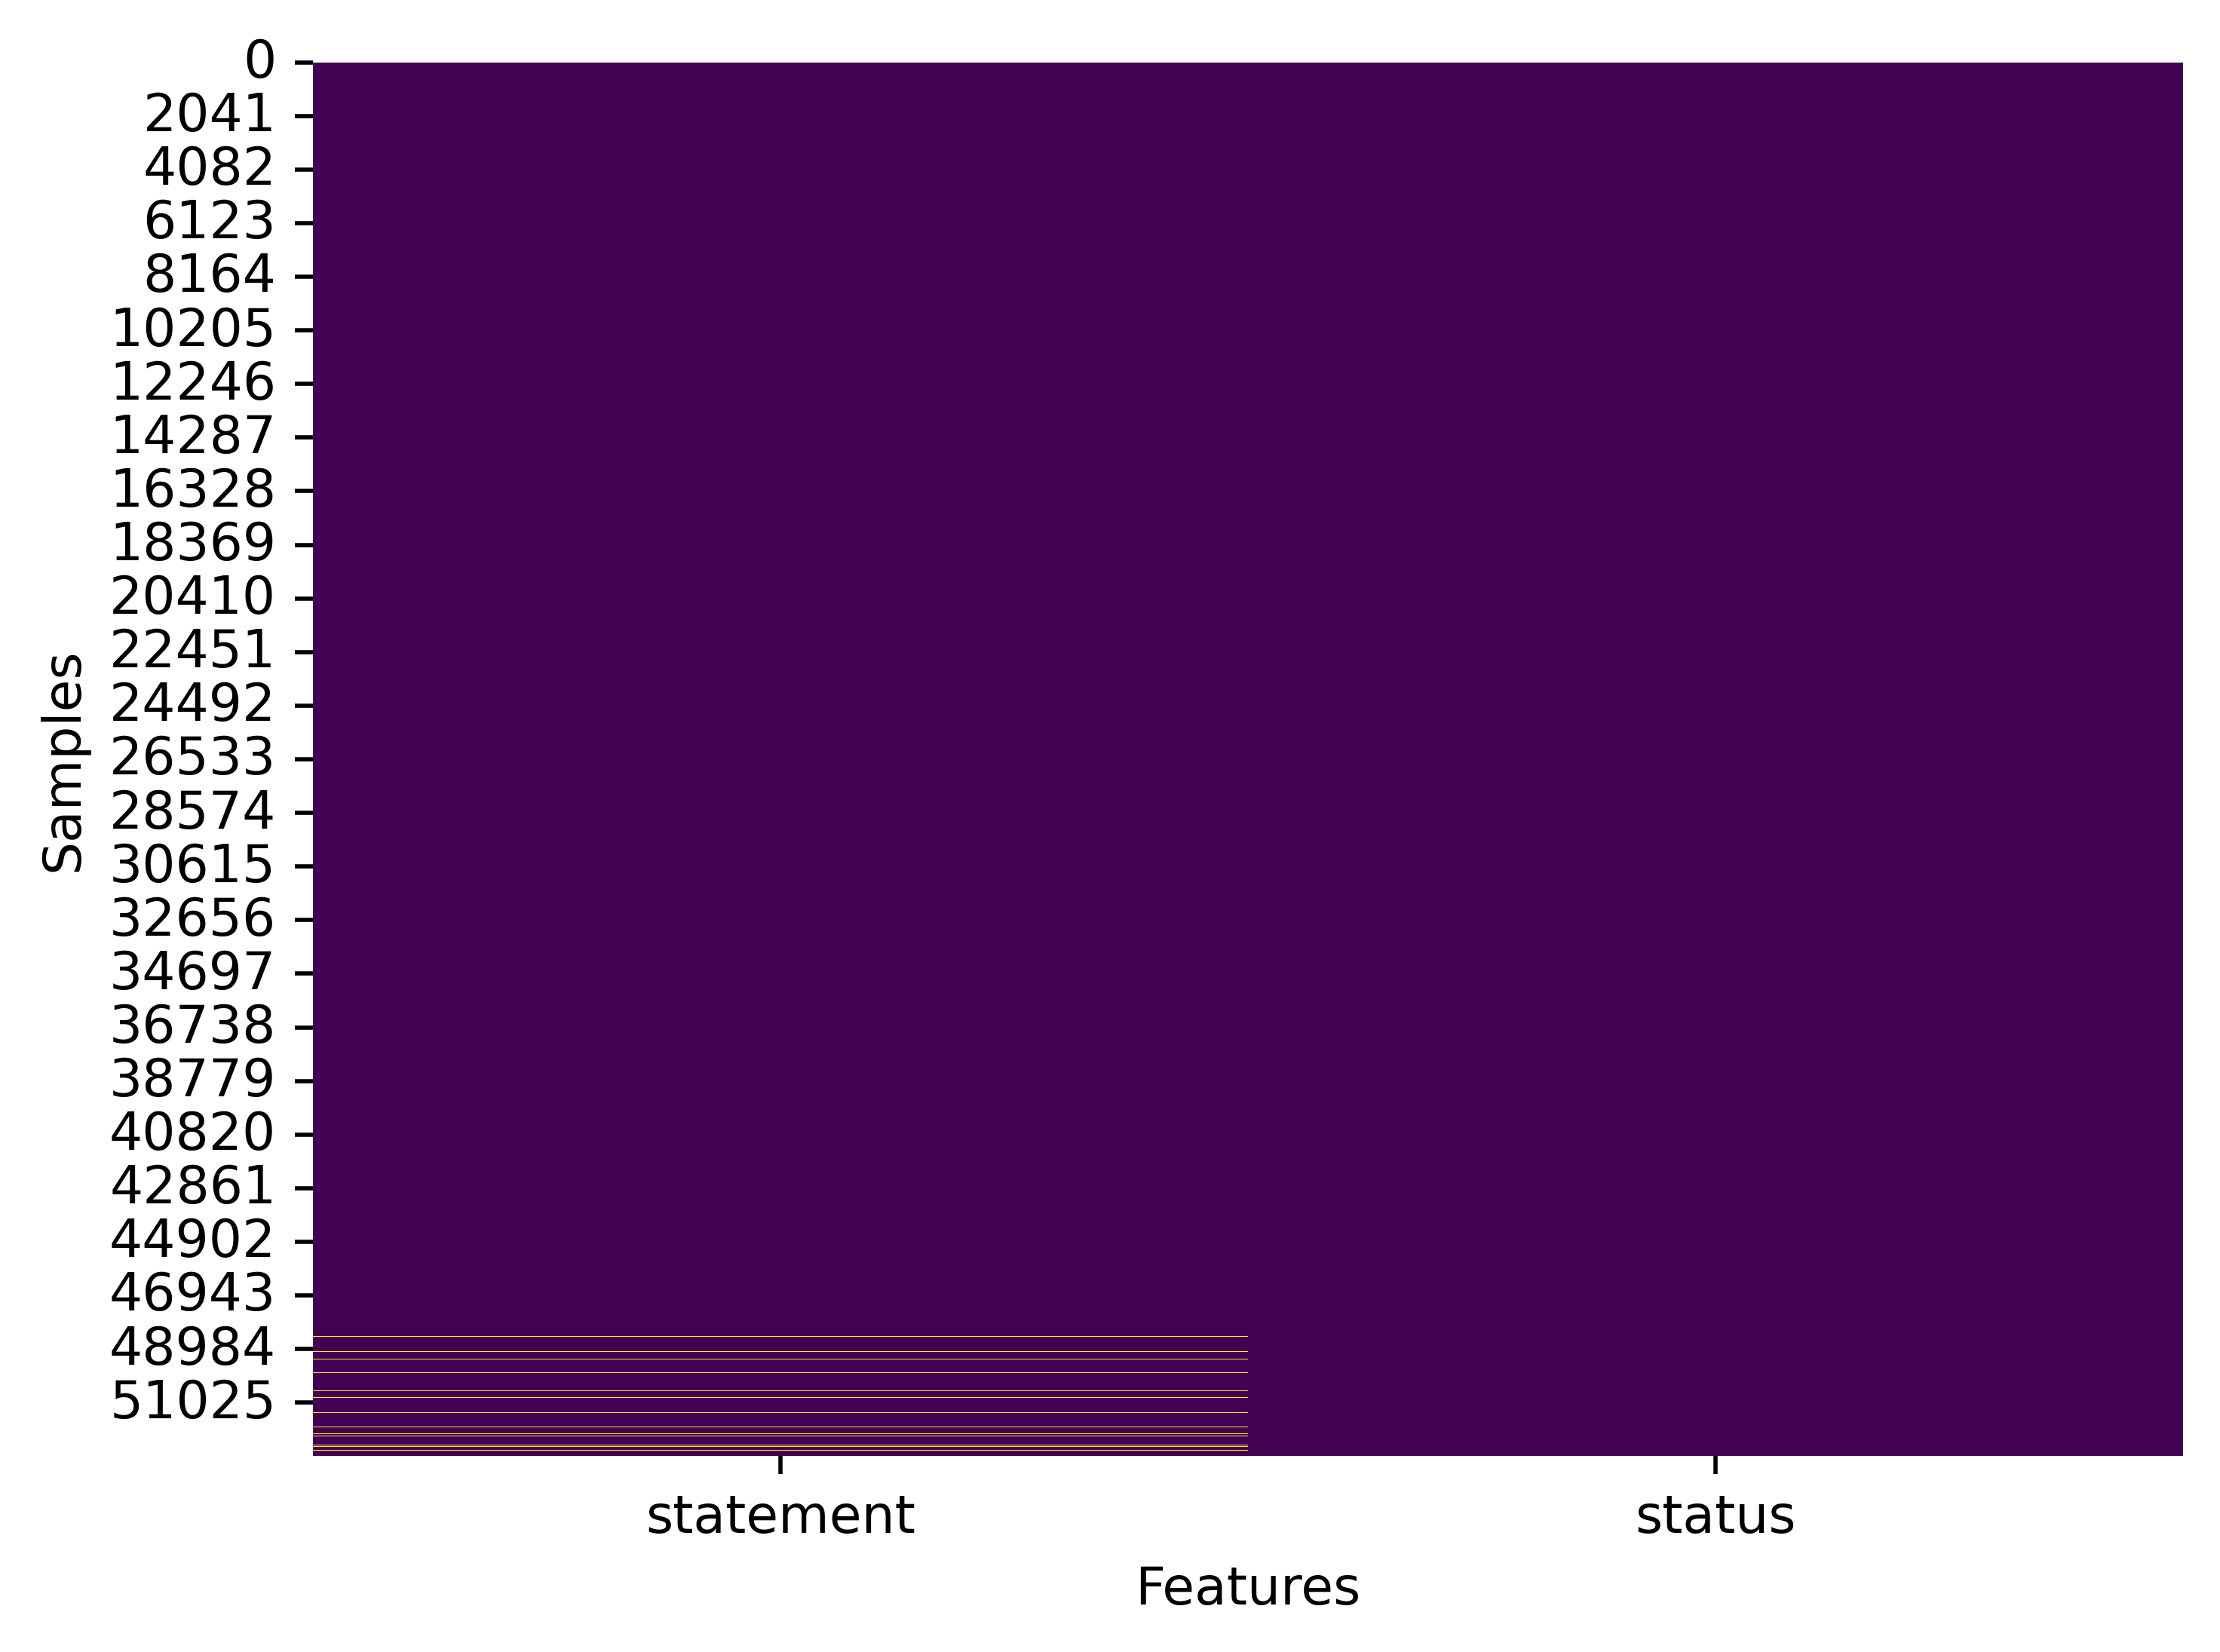

In [2]:
plt.figure(dpi=500) # increase to ensure you can see each row
sns.heatmap(processed_data.isnull() , cbar=False , cmap='viridis')
plt.ylabel('Samples')
plt.xlabel('Features')
plt.show()

In [3]:
processed_data = processed_data.dropna(subset=['statement'])

In [4]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

/opt/homebrew/anaconda3/envs/cs325/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
processed_data['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [6]:
# Maybe one hot encoding?

# Encode the labels
possible_labels = processed_data.status.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Anxiety': 0,
 'Normal': 1,
 'Depression': 2,
 'Suicidal': 3,
 'Stress': 4,
 'Bipolar': 5,
 'Personality disorder': 6}

In [7]:
processed_data['label'] = processed_data.status.replace(label_dict)
processed_data.head()

/var/folders/jj/csybdntn25g1xl6yvmxvxy3m0000gn/T/ipykernel_2009/222621827.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  processed_data['label'] = processed_data.status.replace(label_dict)


,statement,status,label
0,oh my gosh,Anxiety,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,0
3,I've shifted my focus to something else but I'...,Anxiety,0
4,"I'm restless and restless, it's been a month n...",Anxiety,0


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(processed_data.index.values, 
                                                  processed_data.label.values, 
                                                  test_size=0.15, 
                                                  random_state=24, 
                                                  stratify=processed_data.label.values)

processed_data['data_type'] = ['not_set']*processed_data.shape[0]

processed_data.loc[X_train, 'data_type'] = 'train'
processed_data.loc[X_val, 'data_type'] = 'val'

processed_data.groupby(['status', 'label', 'data_type']).count()

statement
status               label data_type           
Anxiety              0     train           3265
                           val              576
Bipolar              5     train           2360
                           val              417
Depression           2     train          13093
                           val             2311
Normal               1     train          13891
                           val             2452
Personality disorder 6     train            916
                           val              161
Stress               4     train           2199
                           val              388
Suicidal             3     train           9054
                           val             1598

In [9]:
processed_data[processed_data.data_type=='train'].statement.values

array(['oh my gosh',
       'trouble sleeping, confused mind, restless heart. All out of tune',
       "I've shifted my focus to something else but I'm still worried",
       ...,
       "Is there any way to sleep better? I can't sleep most of the nights, meds didn't help.",
       'Public speaking tips? Hi, all. I have to give a presentation at work next week (45 minutes long and the CEO will be in attendance). I’m already panicking, as once the anxiety kicks in, I’m certain I’m going to forget everything I’m supposed to say. ( anxiety makes it very difficult for me to focus on anything) Does anyone have any speaking tips that have worked for them in the past? Thanks so much!',
       "I have really bad door anxiety! It's not about being scared I didn't lock the door or something, I'm just really scared of opening doors the wrong way or turning a key the wrong way in front of people or pushing instead of pulling and viceversa, it's honestly debilitating because i feel like I'm gonna d

In [10]:
print(processed_data[processed_data.data_type == 'train'])


                                               statement   status  label  \
0                                             oh my gosh  Anxiety      0   
1      trouble sleeping, confused mind, restless hear...  Anxiety      0   
3      I've shifted my focus to something else but I'...  Anxiety      0   
5      every break, you must be nervous, like somethi...  Anxiety      0   
6      I feel scared, anxious, what can I do? And may...  Anxiety      0   
...                                                  ...      ...    ...   
53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety      0   
53039  selfishness  "I don't feel very good, it's lik...  Anxiety      0   
53040  Is there any way to sleep better? I can't slee...  Anxiety      0   
53041  Public speaking tips? Hi, all. I have to give ...  Anxiety      0   
53042  I have really bad door anxiety! It's not about...  Anxiety      0   

      data_type  
0         train  
1         train  
3         train  
5         train

In [11]:
print(processed_data[processed_data.data_type == 'train'].statement.isnull().sum())

0


In [12]:
print(processed_data[processed_data.data_type == 'val'])

                                               statement   status  label  \
2      All wrong, back off dear, forward doubt. Stay ...  Anxiety      0   
4      I'm restless and restless, it's been a month n...  Anxiety      0   
12     sometimes what is needed when there is a probl...  Anxiety      0   
17                          restive = restless, restless  Anxiety      0   
18     "No regrets or grudges/angry at things that ha...  Anxiety      0   
...                                                  ...      ...    ...   
52986  Long Guided Breathing videos Does anyone have ...  Anxiety      0   
53007  anxiety nausea back at it again literally had ...  Anxiety      0   
53009  .5 mg lorazepam and drinking If I take .5 mg o...  Anxiety      0   
53030  A heart attack would be very obvious right? He...  Anxiety      0   
53034  Neighbours Hello  I’m haveing anxiety because ...  Anxiety      0   

      data_type  
2           val  
4           val  
12          val  
17          val

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    processed_data[processed_data.data_type=='train'].statement.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    processed_data[processed_data.data_type=='val'].statement.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(processed_data[processed_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(processed_data[processed_data.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/homebrew/anaconda3/envs/cs325/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

# Try different values            
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/homebrew/anaconda3/envs/cs325/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [22]:
import random
from tqdm import tqdm

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

KeyboardInterrupt: 